# Phase Curves Part 2: With Post-Processed Input

**Citation: [Robbins-Blanch et al. 2022 "Cloudy and Cloud-free Thermal Phase Curves with PICASO: Applications to WASP-43b" ApJ](http://arxiv.org/abs/2204.03545)**

When you run single 3D spectrum, you only need to compute the chemistry, clouds, radiative transfer for a single set of visible angles -- or a single set of gauss-chebyshev angles. However, for a phase curve, as the planet rotates different angles become visible. Therefore you would need to post-process the input for the complete spherical set of latitude longitude points.

Here you should already run:
1. Required input parameters for a phase curve and an understanding of `xarray`
2. How to run a phase curve without any post-processed input (e.g. by inputing the chemistry yourself)

Here you will learn:

1. How to setup a run that computes chemical equilibrium and then computes a phase curve
2. How to setup a run that runs `virga` and then computes a phase curve


In [1]:
import os
import pandas as pd
import numpy as np

from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Run Thermal Phase Curve w/ Post-Processed Chemical Abundances

You should already know how to go from a GCM input with temperature, abundances to a phase curve calculation. Now we will explore the workflow below where you do **not** have abundances and need to post-process before doing your calculation.

![workflow-phase.png](attachment:workflow-phase.png)

In [2]:
opacity = jdi.opannection(wave_range=[1,1.7])

### Normal starting case

In [3]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True) #here is our required starting temp map input

### Regrid to generic latitude, longitude grid (Optional)

This will determine how many chemistry calculations we perform. Note that this step is optional! You are always welcome to use the same process below with your high resolution gcm grid.

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


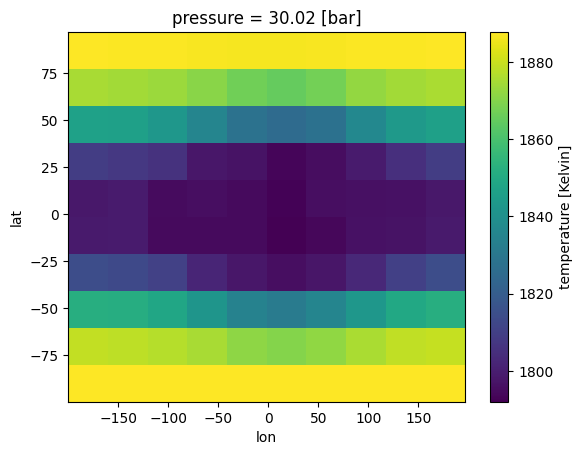

In [4]:
gcm_out_lores = jdi.regrid_xarray(gcm_out,num_tangle=3, latitude = np.linspace(-90, 87, 10),
                                 longitude = np.linspace(-180, 177, 10) )
gcm_out_lores['temperature'].isel(pressure=5).plot(x='lon',y='lat')

### Post-process chemistry

We will use the same chemeq_3d function used previously in the 3D spectra routines

In [5]:
case_3d = jdi.inputs()
case_3d.inputs['atmosphere']['profile'] = gcm_out_lores
case_3d.chemeq_3d(n_cpu=3)

See output on generic grid you created

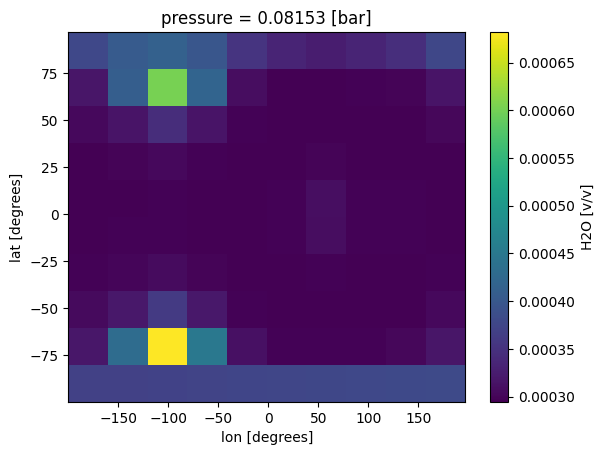

In [6]:
case_3d.inputs['atmosphere']['profile']['H2O'].isel(pressure=30).plot(x='lon',y='lat')

### Add to bundle, compute phase curve

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-pac

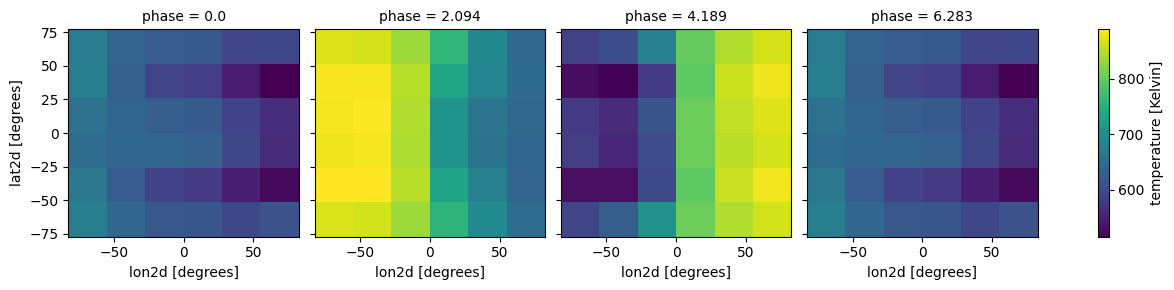

In [7]:
n_phases = 4
min_phase = 0
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
case_3d.phase_angle(phase_grid=phase_grid,
                    num_gangle=6, num_tangle=6,calculation='thermal')

#NOTE: notice below that we are NOT submitting a dataframe , because we have already done so
#above in preparation for chemeq_3d
case_3d.atmosphere_4d(shift = np.zeros(n_phases),zero_point='night_transit',
                                     plot=True,verbose=False)

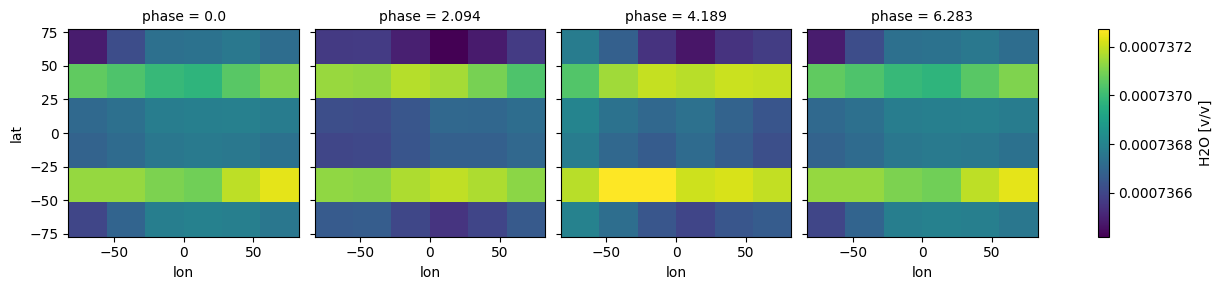

In [8]:
case_3d.inputs['atmosphere']['profile']['H2O'].isel(pressure=52).plot(
                                              x='lon', y ='lat',
                                              col='phase',col_wrap=4)

Set gravity and stellar parameters as usual and proceed with phase curve calculation

In [9]:
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'))
allout = case_3d.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

### Analyze Phase Curves

Proceed with analysis as usual!

In [10]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout.keys():
    w,f = jdi.mean_regrid(allout[iphase]['wavenumber'],
                               allout[iphase]['fpfs_thermal'],R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))

## Run Thermal Phase Curve w/ Post-Processed `virga` Models

Here we are putting it all together!

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-pac

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-pac

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-pac

Currently computing Phase (2, np.float64(4.1887902047863905))
Currently computing Phase (3, np.float64(6.283185307179586))
Currently computing Phase (2, np.float64(4.1887902047863905))


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


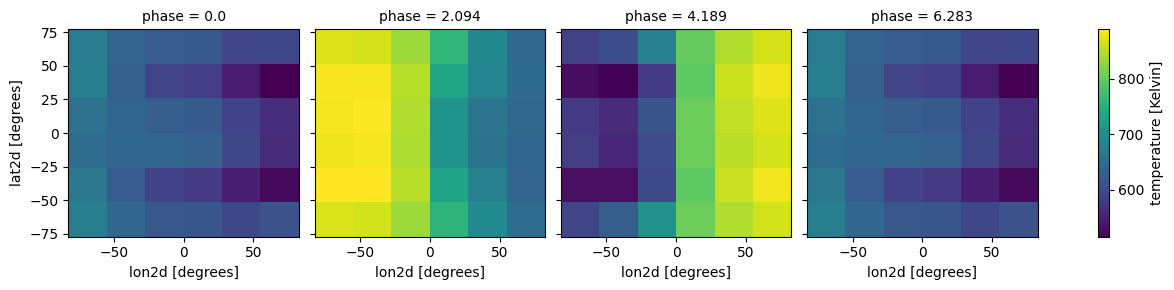

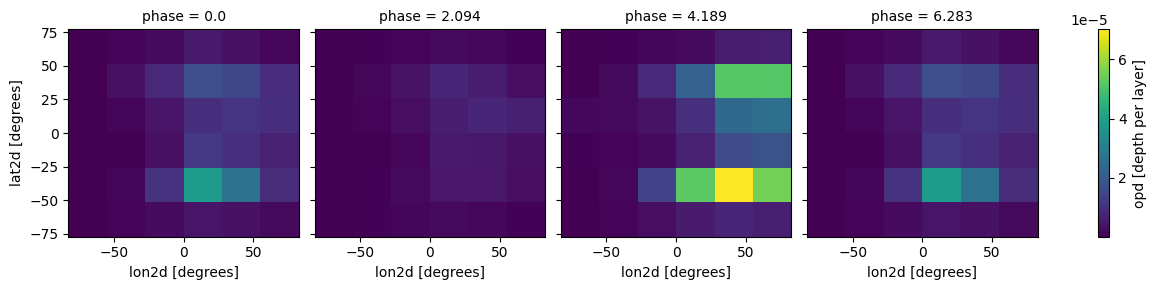

In [11]:
#Start with you high resolution temperature, kz map
gcm_out =  jdi.HJ_pt_3d(as_xarray=True,add_kz=True)
#regrid to make it more manageable, remember this is optional!
gcm_out_lores = jdi.regrid_xarray(gcm_out,num_tangle=3, latitude= np.linspace(-90, 87, 10),
                                 longitude = np.linspace(-180, 177, 10) )
#start your picaso bundle and add your atmospheric profile
case = jdi.inputs()

#add stellar and gravity parameters
case.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'))

case.inputs['atmosphere']['profile'] = gcm_out_lores
#post-process chemistry
case.chemeq_3d(n_cpu=3)
# mieff_directory = '/data/virga/'
mieff_directory  = os.path.join(os.getenv('picaso_refdata'),'virga') #recommended download #1 above
#post-process clouds
clds = case.virga_3d(['MnS'], mieff_directory,fsed=1,kz_min=1e10,
                        verbose=False,full_output=True,n_cpu=1
                       )
#define phase angle gird
case.phase_angle(phase_grid=phase_grid,
                    num_gangle=6, num_tangle=6,calculation='thermal')
#create your 4th phase dimension with the shift parameter
case.atmosphere_4d(shift = np.zeros(n_phases),zero_point='night_transit',
                                     plot=True,verbose=False)
case.clouds_4d(plot=True,verbose=False)
#RUN PHASE CURVE WAHOO!!
allout = case.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

In [12]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout.keys():
    w,f = jdi.mean_regrid(allout[iphase]['wavenumber'],
                               allout[iphase]['fpfs_thermal'],R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))